In [1]:
import numpy as np
from scipy.spatial.distance import cdist

In [2]:
from  heron import  regression
from heron import data
from heron import kernels
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
x = np.linspace(-10, 10,100)#, np.linspace(-10, 10, 100)
y1 = 3 * np.cos(x) + 4 * np.cos(2*x)
y2 = 2 * np.cos(x + 1.0) + 3 * np.cos(2*x + 1.0)
y3 = 6 * np.cos(x + 1.0) + 3 * np.cos(2*x + 1.0)
y = np.vstack([y1,y2, y3])

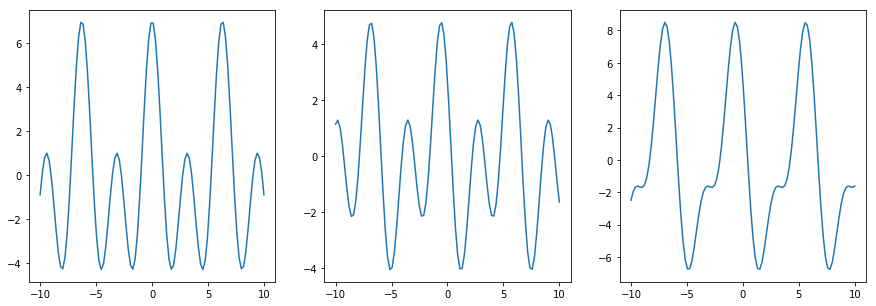

In [4]:
f, ax = plt.subplots(1,3, figsize= (15,5))
ax[0].plot(x,y1)
ax[1].plot(x,y2)
ax[2].plot(x,y3)

In [5]:
fake = data.Data(np.atleast_2d(x[::2]).T, np.atleast_2d(y)[:,::2].T,              
                    target_names = ["Times", "Mass", "Spin"],
                    label_names = ["hp strain"],
                    test_size = 0,
                    )

/home/daniel/.virtualenvs/heron/local/lib/python2.7/site-packages/heron-0.1.0-py2.7.egg/heron/data.py:121: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [6]:
x0 = [(1/np.std(fake.labels))**2, 25] #(1/np.std(fake.labels))**2
gp = regression.Regressor(fake, kernel=kernels.SquaredExponential(ndim=1),  tikh=1e-4)
gp.set_hyperparameters(x0)

In [7]:
import scipy.linalg

In [8]:
new_point = np.linspace(-10,10,1000)
pred = gp.prediction(np.atleast_2d(new_point))

/home/daniel/.virtualenvs/heron/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


ValueError: operands could not be broadcast together with shapes (1000,3) (1000,) 

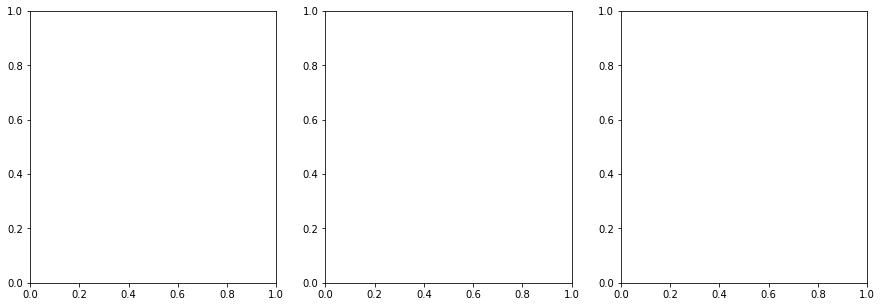

In [10]:
#gp.B_matrix = [[.9,0.1],[0.1,.9]]
gp.update()
pred = gp.prediction(np.atleast_2d(new_point))
f, ax = plt.subplots(1,3, figsize= (15,5))
err = np.sqrt(np.diag(pred[1])[:1000])
predi = pred[0] #fake.denormalise(pred[0], 'label')[:100,0]
ax[0].fill_between(new_point, (predi+err), (predi-err), alpha=0.2)
ax[0].plot(new_point, predi)
ax[0].plot(fake.denormalise(fake.targets, 'target'),fake.labels[:,0],'.')

err = np.sqrt(np.diag(pred[1])[1000:2000])
predi = pred[0][1000:2000].T[0] #fake.denormalise(pred[0], 'label')[:100,0]
ax[1].fill_between(new_point, (predi+err), (predi-err), alpha=0.2)

ax[1].plot(new_point, predi)
ax[1].plot(fake.denormalise(fake.targets, 'target'),fake.labels[:,1],'.')
ax[0].set_ylim([-.4,1.4]);
ax[1].set_ylim([-.4,1.4]);

err = np.sqrt(np.diag(pred[1])[2000:3000])
predi = pred[0][2000:3000].T[0] #fake.denormalise(pred[0], 'label')[:100,0]
ax[2].fill_between(new_point, (predi+err), (predi-err), alpha=0.2)

ax[2].plot(new_point, predi)
ax[2].plot(fake.denormalise(fake.targets, 'target'),fake.labels[:,2],'.')
ax[2].set_ylim([-.4,1.4]);
print gp.loglikelihood()

In [11]:
from scipy.optimize import minimize

In [17]:
gp.B_matrix

array([[ 1.0003,  0.    ,  0.    ],
       [ 0.    ,  1.0003,  0.    ],
       [ 0.    ,  0.    ,  1.0003]])

In [14]:
def nll(p):
        oldb = gp.B_matrix.copy()
        pn = gp.output_dim**2
        gp.set_bmatrix(p[:pn])
        gp.set_hyperparameters(p[pn:])
        ll = gp.loglikelihood()
        return -ll if np.isfinite(ll) else 1e25

B0 = np.hstack([gp.B_matrix.reshape(-1), gp.kernel.flat_hyper])
res = minimize(nll, B0, method='BFGS', options={'disp': True, 'maxiter':10000})
gp.set_bmatrix(res.x[:gp.output_dim**2])
gp.set_hyperparameters(res.x[gp.output_dim**2:])

/home/daniel/.virtualenvs/heron/local/lib/python2.7/site-packages/heron-0.1.0-py2.7.egg/heron/kernels.py:20: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


         Current function value: 230.563668
         Iterations: 0
         Function evaluations: 259
         Gradient evaluations: 19


/home/daniel/.virtualenvs/heron/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/home/daniel/.virtualenvs/heron/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in sqrt


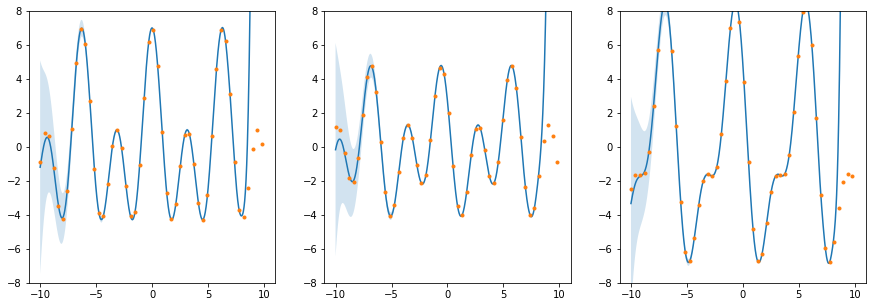

In [15]:
pred = gp.prediction(np.atleast_2d(new_point))
f, ax = plt.subplots(1,3, figsize= (15,5))
err = np.sqrt(np.diag(pred[1])[:1000])
predi = fake.denormalise(pred[0], 'label')
ax[0].fill_between(new_point, (predi[:,0]+err), (predi[:,0]-err), alpha=0.2)
ax[0].plot(new_point, predi[:,0])
ax[0].plot(fake.denormalise(fake.targets, 'target'),fake.denormalise(fake.labels, "label")[:,0],'.')

err = np.sqrt(np.diag(pred[1])[1000:2000])

ax[1].fill_between(new_point, (predi[:,1]+err), (predi[:,1]-err), alpha=0.2)

ax[1].plot(new_point, predi[:,1])
ax[1].plot(fake.denormalise(fake.targets, 'target'),fake.denormalise(fake.labels, "label")[:,1],'.')
ax[0].set_ylim([-8,8]);
ax[1].set_ylim([-8,8]);

#predi = fake.denormalise(pred[0][2000:3000], 'label').T[0]
ax[2].fill_between(new_point, (predi[:,2]+err), (predi[:,2]-err), alpha=0.2)

ax[2].plot(new_point, predi[:,2])
ax[2].plot(fake.denormalise(fake.targets, 'target'),fake.denormalise(fake.labels, "label")[:,2],'.')
ax[2].set_ylim([-8,8]);

In [107]:
predi = fake.denormalise(pred[0].reshape(-1,3), 'label')